# Semantic Segmentation

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch

from semantic_segmentation.data.segmentation_dataset import SegmentationData, label_img_to_rgb
from semantic_segmentation.data.download_utils import download_dataset
from semantic_segmentation.util import visualizer, save_model
from semantic_segmentation.networks.segmentation_nn import SegmentationNN, DummySegmentationModel, Encoder, Decoder

#set up default cuda device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

## Load and Visualize Data

#### MSRC-v2 Segmentation Dataset


In [3]:
path = os.path.dirname(os.path.abspath(os.getcwd()))
data_root = os.path.join(path, 'datasets','segmentation')


download_dataset(
    data_dir=data_root,
    dataset_zip_name='segmentation_data.zip',
    force_download=False,
)

train_data = SegmentationData(image_paths_file=f'{data_root}/segmentation_data/train.txt')
val_data = SegmentationData(image_paths_file=f'{data_root}/segmentation_data/val.txt')
test_data = SegmentationData(image_paths_file=f'{data_root}/segmentation_data/test.txt')


100%|██████████| 56/56 [00:03<00:00, 16.77it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train size: 276
Validation size: 59
Img size:  torch.Size([3, 240, 240])
Segmentation size:  torch.Size([240, 240])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


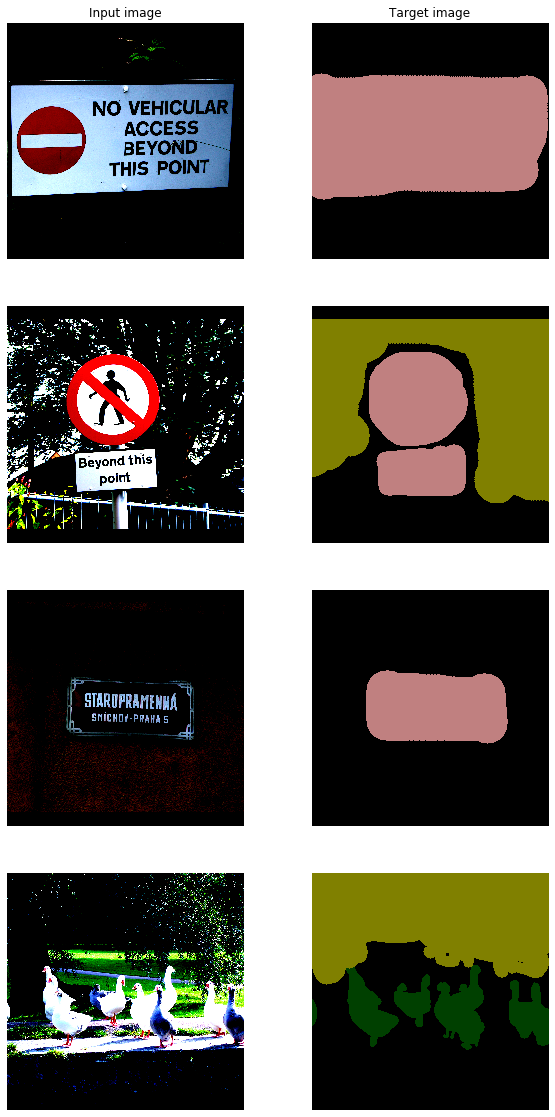

In [4]:
print("Train size: %i" % len(train_data))
print("Validation size: %i" % len(val_data))
print("Img size: ", train_data[0][0].size())
print("Segmentation size: ", train_data[0][1].size())

num_example_imgs = 4
plt.figure(figsize=(10, 5 * num_example_imgs))
for i, (img, target) in enumerate(train_data[:num_example_imgs]):
    # img
    plt.subplot(num_example_imgs, 2, i * 2 + 1)
    plt.imshow(img.numpy().transpose(1,2,0))
    plt.axis('off')
    if i == 0:
        plt.title("Input image")

    # target
    plt.subplot(num_example_imgs, 2, i * 2 + 2)
    plt.imshow(label_img_to_rgb(target.numpy()))
    plt.axis('off')
    if i == 0:
        plt.title("Target image")
plt.show()

# 2. Semantic Segmentation

## Dummy Model

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


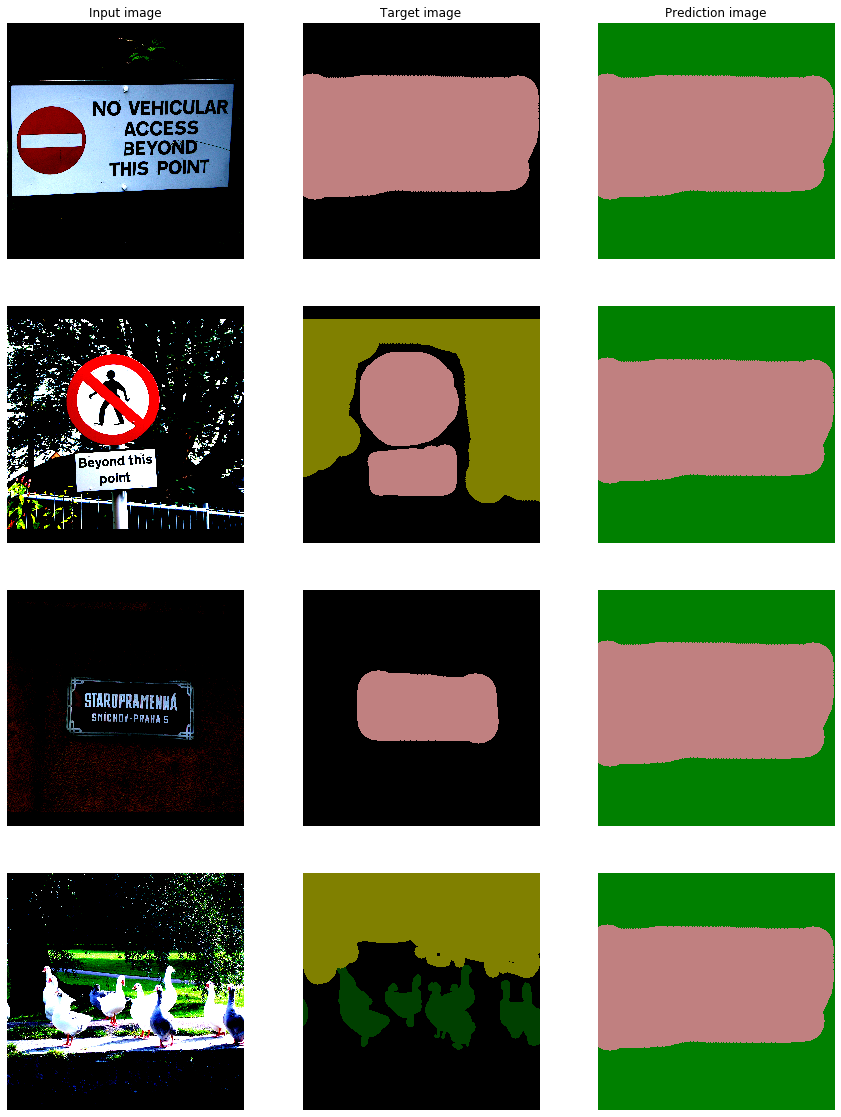

In [5]:
dummy_model = DummySegmentationModel(target_image=train_data[0][1])

# Visualization function
visualizer(dummy_model, train_data)

## Loss and Metrics

In [6]:
loss_func = torch.nn.CrossEntropyLoss(ignore_index=-1, reduction='mean')

for (inputs, targets) in train_data[0:4]:
    inputs, targets = inputs, targets
    outputs = dummy_model(inputs.unsqueeze(0))
    losses = loss_func(outputs, targets.unsqueeze(0))
    print(losses)

tensor(2.2072)
tensor(2.9416)
tensor(2.2076)
tensor(3.2083)


In [7]:
def evaluate_model(model, dataloader):
    test_scores = []
    model.eval()
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model.forward(inputs)
        _, preds = torch.max(outputs, 1)
        targets_mask = targets >= 0
        test_scores.append(np.mean((preds.cpu() == targets.cpu())[targets_mask].numpy()))

    return np.mean(test_scores)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=1,shuffle=False,num_workers=0)
print(evaluate_model(dummy_model, test_loader))

0.14179702232915609


## Step 1: Model

In [8]:
encoder = Encoder(name="alexnet")
decoder = Decoder(name="alexnet", num_classes=23)

hparams = {
    "encoder": encoder,
    "decoder": decoder,
    "learning_rate": 1e-03,
    "batch_size": 8,
    "weight_decay": 5e-09,
    "feature_extract": True,
    "n_hidden_classifier": 256,
    "dropout_proba": 0.5,
    "input_size": 240
    #"scheduler_factor": 0.1,
    #"scheduler_patience": 1,
}

In [10]:
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

model = SegmentationNN(hparams=hparams)

model.prepare_data()

logger = TensorBoardLogger("runs")

early_stop_callback = EarlyStopping(
    monitor="val_loss",
    patience=5,
    verbose=True,
    mode="min",
)

#lr_monitor = LearningRateMonitor(logging_interval="epoch")

trainer = Trainer(
    weights_summary=None,
    profiler=False,
    max_epochs=10,
    #gpus=1, # Use GPU if available,
    logger=logger,
    callbacks=[early_stop_callback]

)

trainer.fit(model)

100%|██████████| 56/56 [00:03<00:00, 17.36it/s]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
100%|██████████| 56/56 [00:02<00:00, 18.69it/s]


1

In [11]:
evaluate_model(model, test_loader)

Validation-Accuracy: 73.47052421227858%
Congrats! The accuracy passes the threshold, you can try to submit your model to server now.


# Visualization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


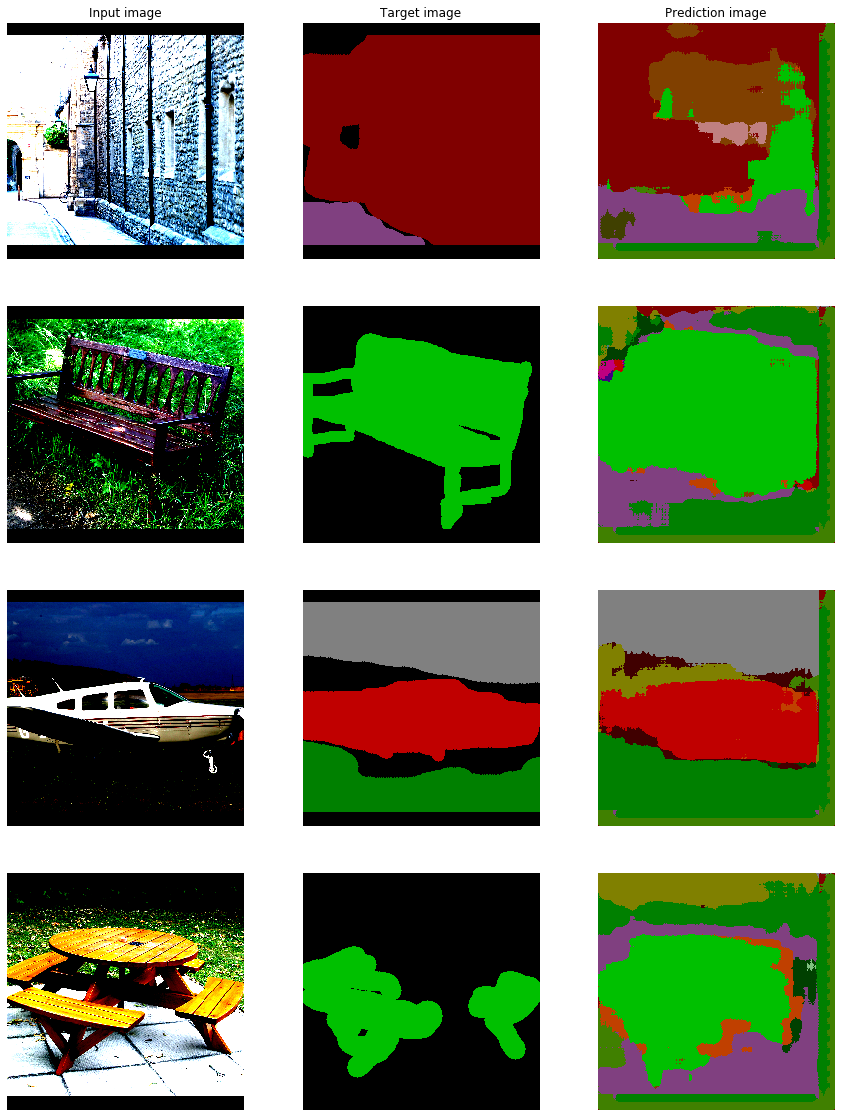

In [12]:
visualizer(model, test_data)

In [17]:
torch.save(model.state_dict(), os.getcwd()+"mymod.p")

In [18]:
model = SegmentationNN(hparams=hparams)
model.load_state_dict(torch.load(os.getcwd()+"mymod.p"))
model.eval()

SegmentationNN(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  )
  (decoder): Decoder(
    (decoder): Sequential(
      (0): ConvTran